# Business Analytics
## Nomis and Logistic Regression
(C) 2021

In [47]:
from IPython.display import HTML, display

def optional_material():
    '''
    When run in a cell, this function will color the cell blue to indicate
    the material is optional
    '''
    script =  "var cell = this.closest('.code_cell');"
    script += "var editor = cell.querySelector('.input_area');"
    script += "editor.style.background='#bde4f0';"
    script += "this.parentNode.removeChild(this)"
    
    display(HTML(f'<img src onerror="{script}">'))
    
optional_material()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:900px !important; }</style>"))

## e-Car at Nomis

In [48]:
import pandas as pd

df_nomis = pd.read_excel('/Users/gujiajun/Downloads/Nomis data.xlsx')

df_nomis.head()

,Tier,FICO,Approve Date,Term,Amount,Previous Rate,Car Type,Competition rate,Outcome,Rate,Cost of Funds,Partner Bin
0,3,695,2002-07-01,72,35000.0,,N,6.25,0,7.49,1.8388,1
1,1,751,2002-07-01,60,40000.0,,N,5.65,0,5.49,1.8388,3
2,1,731,2002-07-01,60,18064.0,,N,5.65,0,5.49,1.8388,3
3,4,652,2002-07-01,72,15415.0,,N,6.25,0,8.99,1.8388,3
4,1,730,2002-07-01,48,32000.0,,N,5.65,0,5.49,1.8388,1


## Exploring a segment

In [49]:
df_segment = df_nomis[(df_nomis['Car Type'] == 'U')
                         & (df_nomis['FICO'] >= 684)
                         & (df_nomis['FICO'] <= 712)
                         & (df_nomis['Term'] == 60)
                         & (df_nomis['Amount'] >= 17800)
                         & (df_nomis['Amount'] <= 25000)].copy()

len(df_segment)

1540

In [50]:
# Install numpy financial the first time you run this
!pip install numpy_financial


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [51]:
import numpy_financial as npf

def loan_rev(APR, cost_of_funds, term, amount):
    return -npf.pmt(APR/(100*12), term, amount) + npf.pmt(cost_of_funds/(100*12), term, amount)

In [52]:
optional_material()

import numpy_financial as npf

# For each loan in the segment, figure out the revenue to e-Car,
# equal to the amount they get from the customer minus the amount
# they have to pay for the funds

for i in df_segment.index:
    rate = df_segment.loc[i, 'Rate']
    amount = df_segment.loc[i, 'Amount']
    cost_of_funds = df_segment.loc[i, 'Cost of Funds']
    term = df_segment.loc[i, 'Term']
        
    df_segment.loc[i, 'monthly_payment'] = loan_rev(rate, cost_of_funds, term, amount)

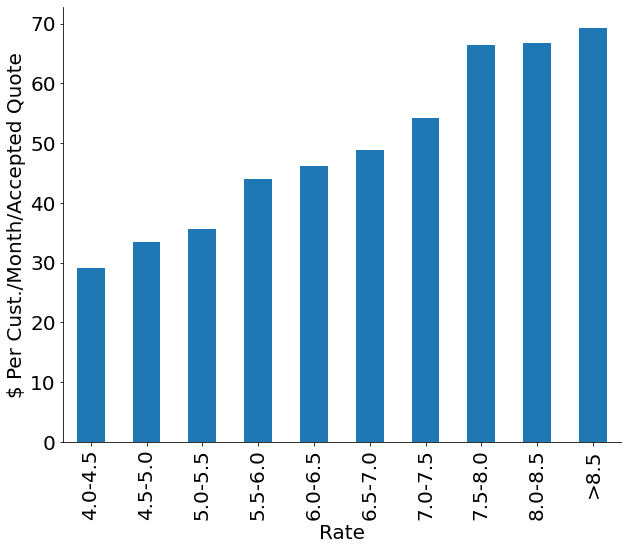

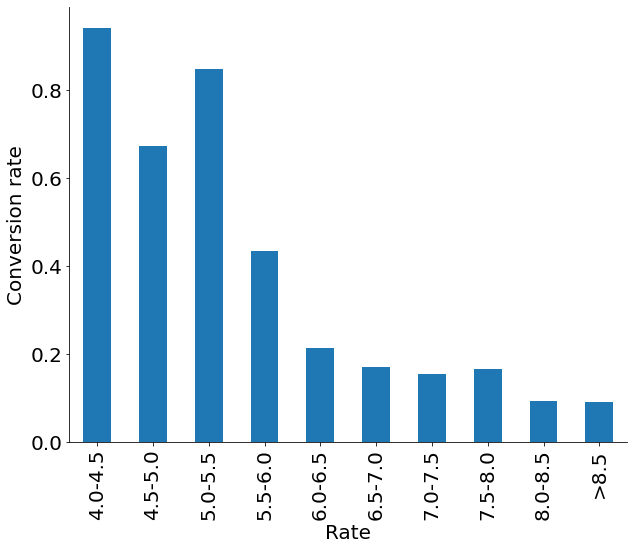

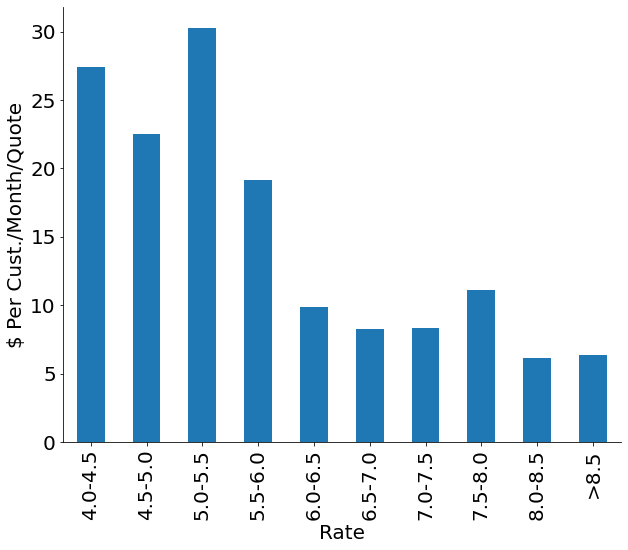

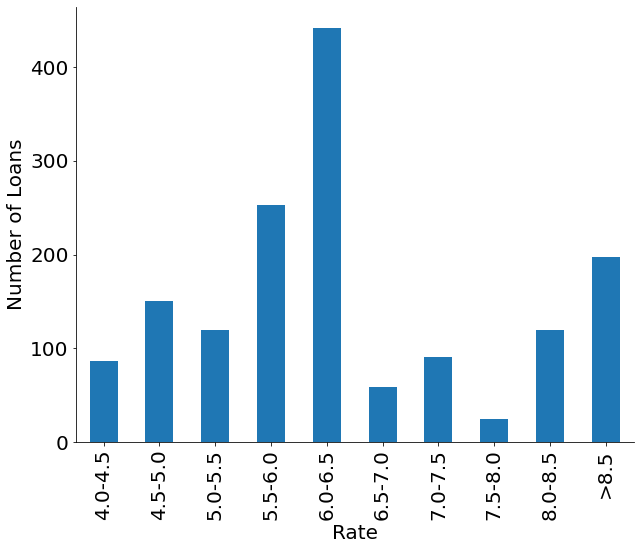

In [53]:
optional_material()

import matplotlib.pyplot as plt
import seaborn as sns

def find_bin(x):
    '''
    This function takes a given rate, and returns the bin of width
    0.5 that the rate is in. For example, an input of 2.3 would
    result in a bin of 2-2.5
    '''
    if x > 8.5:
        return ">8.5"
    else:
        if round(x) <= x:
            return(f'{float(round(x))}-{float(round(x)+0.5)}')
        else:
            return(f'{float(round(x)-0.5)}-{float(round(x))}')

# Create a histogram of revenue to e-Car as a function of rate
# offered        
plt.figure(figsize=(10, 8))
(df_segment[df_segment.Outcome == 1]
           .groupby(df_segment[df_segment.Outcome == 1].Rate.apply(find_bin))
           .monthly_payment
           .mean()
           .plot(kind='bar'))
plt.xlabel('Rate', fontsize=20)
plt.ylabel('\$ Per Cust./Month/Accepted Quote', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

# Create a histogram with conversion rate vs. APR
plt.figure(figsize=(10, 8))
df_segment.groupby(df_segment.Rate.apply(find_bin)).Outcome.mean().plot(kind='bar')
plt.xlabel('Rate', fontsize=20)
plt.ylabel('Conversion rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

# Create a histogram multiplying the previous two
plt.figure(figsize=(10, 8))
(df_segment[df_segment.Outcome == 1]
           .groupby(df_segment[df_segment.Outcome == 1].Rate.apply(find_bin))
           .monthly_payment
           .mean()
  * df_segment.groupby(df_segment.Rate.apply(find_bin)).Outcome.mean()).plot(kind='bar')
plt.xlabel('Rate', fontsize=20)
plt.ylabel('\$ Per Cust./Month/Quote', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.figure(figsize=(10, 8))
df_segment.groupby(df_segment.Rate.apply(find_bin)).Outcome.count().plot(kind='bar')
plt.xlabel('Rate', fontsize=20)
plt.ylabel('Number of Loans', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

## Estimating the demand function

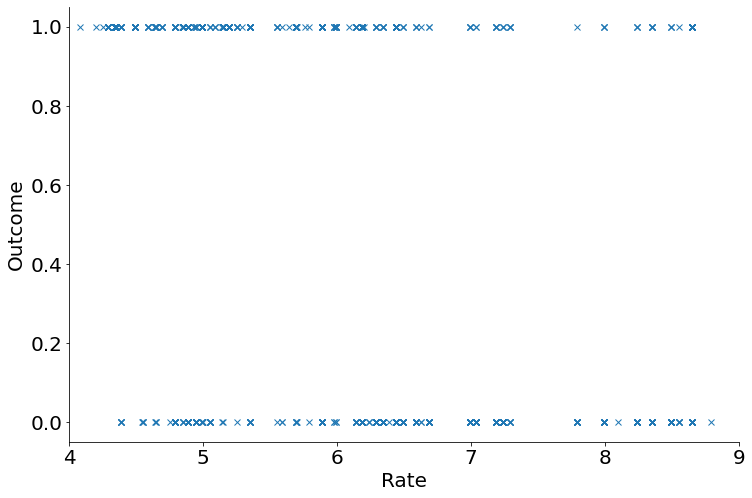

In [54]:
plt.figure(figsize=(12, 8))
plt.plot(df_segment.Rate, df_segment.Outcome, linewidth=0, marker='x')
plt.xlabel('Rate', fontsize=20)
plt.ylabel('Outcome', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([4,9])
sns.despine()

In [55]:
import statsmodels.formula.api as smf

linear_reg = smf.ols('Outcome ~ Rate', data=df_segment).fit()

linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     462.1
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           7.80e-90
Time:                        11:58:17   Log-Likelihood:                -846.08
No. Observations:                1540   AIC:                             1696.
Df Residuals:                    1538   BIC:                             1707.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4954      0.054     27.591      0.000       1.389       1.602
Rate          -0.1771      0.008    -21.496      0.000      -0.193      -0.161
==============================================================================
Omnibus:                      200.970   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.031
Skew:                           0.424   Prob(JB):                     1.04e-20
Kurtosis:                       2.154   Cond. No.                         34.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

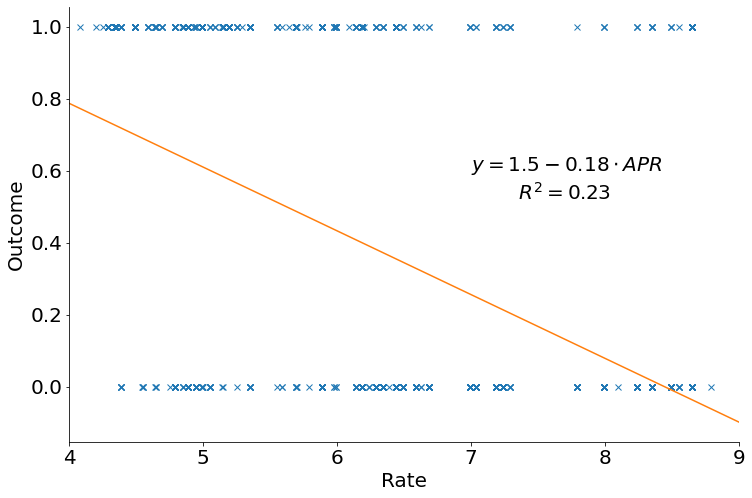

In [56]:
import numpy as np

plt.figure(figsize=(12, 8))
plt.plot(df_segment.Rate, df_segment.Outcome, linewidth=0, marker='x')

x_points = np.linspace(4,9)
y_points = linear_reg.predict(pd.DataFrame({'Rate':x_points}))
plt.plot(x_points, y_points)

plt.text(7, 0.6, f'$y = {round(linear_reg.params[0],2)} {round(linear_reg.params[1],2)} \cdot APR$', fontsize=20)
plt.text(7.35, 0.52, f'$R^2 = {round(linear_reg.rsquared,2)}$', fontsize=20)

plt.xlabel('Rate', fontsize=20)
plt.ylabel('Outcome', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([4,9])
sns.despine()

## Logistic regression in Python

In [57]:
import statsmodels.formula.api as smf

logistic_reg = smf.logit('Outcome ~ Rate', data=df_segment).fit()

logistic_reg.summary()

Optimization terminated successfully.
         Current function value: 0.510580
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                 1540
Model:                          Logit   Df Residuals:                     1538
Method:                           MLE   Df Model:                            1
Date:                Wed, 20 Sep 2023   Pseudo R-squ.:                  0.2138
Time:                        11:58:18   Log-Likelihood:                -786.29
converged:                       True   LL-Null:                       -1000.1
Covariance Type:            nonrobust   LLR p-value:                 5.225e-95
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3603      0.421     15.115      0.000       5.536       7.185
Rate          -1.1278      0.070    -16.173      0.000      -1.264      -0.991
==============================================================================
"""

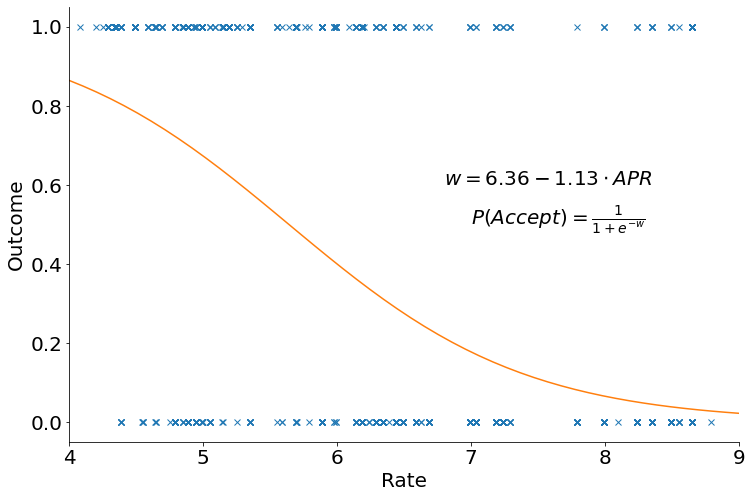

In [58]:
import numpy as np

plt.figure(figsize=(12, 8))
plt.plot(df_segment.Rate, df_segment.Outcome, linewidth=0, marker='x')

x_points = np.linspace(4,9)
y_points = logistic_reg.predict(pd.DataFrame({'Rate':x_points}))
plt.plot(x_points, y_points)

plt.text(6.8, 0.6, f'$w = {round(logistic_reg.params[0], 2)} {round(logistic_reg.params[1],2)} \cdot APR$', fontsize=20)
plt.text(7, 0.5, '$P(Accept) = \\frac{1}{1+e^{-w}}$', fontsize=20)
#plt.text(8.7, 0.52, f'$R^2 = {round(linear_reg.rsquared,2)}$', fontsize=20)

plt.xlabel('Rate', fontsize=20)
plt.ylabel('Outcome', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([4,9])
sns.despine()

In [59]:
logistic_reg.params

Intercept    6.360323
Rate        -1.127767
dtype: float64

In [60]:
df_segment[['Rate']].head(2)

,Rate
358,6.19
466,6.19


In [61]:
logistic_reg.predict(df_segment[['Rate']].head(2))

358    0.349656
466    0.349656
dtype: float64

In [62]:
1/(1+np.exp(-(6.3603-1.1278*6.19)))

0.34960361863426076

## A deeper dive into logistic regression

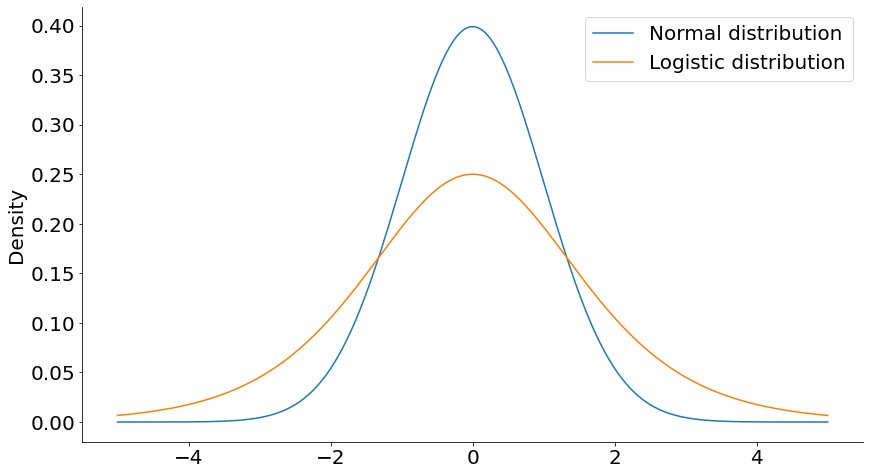

In [63]:
import scipy as sp

x_vals = np.linspace(-5, 5, num=200)
y_normal = sp.stats.norm.pdf(x_vals)
y_logistic = sp.stats.logistic.pdf(x_vals)

plt.figure(figsize=(14, 8))

plt.plot(x_vals, y_normal, label='Normal distribution')
plt.plot(x_vals, y_logistic, label='Logistic distribution')

plt.ylabel('Density', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)

sns.despine()

## Gradient descent for logistic regression

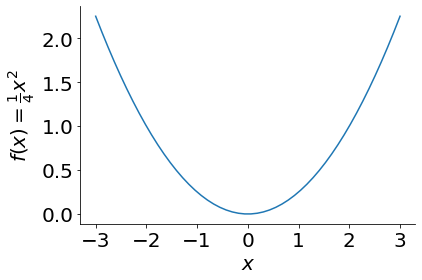

In [64]:
optional_material()

# Plots for slides

x = np.linspace(-3, 3)
y = 0.25*x**2

plt.plot(x,y)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel('$x$', fontsize=20)
plt.ylabel('$f(x) = \\frac{1}{4}x^2$', fontsize=20)

sns.despine()

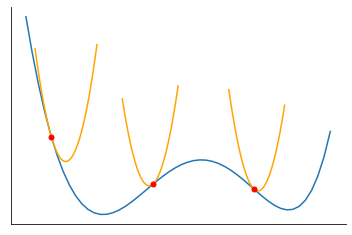

In [65]:
optional_material()

# Plots for slides


f = lambda x : 0.0292*x**5 - 0.1875*x**4 - 0.9708*x**3 + 9.3875*x**2 - 19.958*x + 12.7
f_prime = lambda x : 5*0.0292*x**4 - 4*0.1875*x**3 - 3*0.9708*x**2 + 2*9.3875*x - 19.958

x = np.linspace(0, 6)
y = f(x)
plt.plot(x,y)

def plot_parabola(x, minus, plus):
    xx = np.linspace(x-minus, x+plus)
    yy = f(x) + f_prime(x)*(xx-x) + 20*(xx-x)**2

    plt.plot(xx, yy, color='orange')
    plt.plot(x, f(x), marker='o', color='red', markersize=5)

plot_parabola(0.5, 0.32, 0.9)
plot_parabola(2.5, 0.6, 0.5)
plot_parabola(4.5, 0.5, 0.6)
    
plt.xticks([], fontsize=20)
plt.yticks([], fontsize=20)

sns.despine()

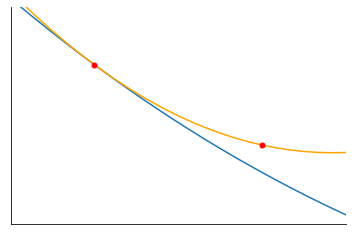

In [66]:
optional_material()

# Plots for slides

f = lambda x : 0.0292*x**5 - 0.1875*x**4 - 0.9708*x**3 + 9.3875*x**2 - 19.958*x + 12.7
f_prime = lambda x : 5*0.0292*x**4 - 4*0.1875*x**3 - 3*0.9708*x**2 + 2*9.3875*x - 19.958

x = np.linspace(0.0, 1)
y = f(x)
plt.plot(x,y)

def plot_parabola(x, minus, plus):
    xx = np.linspace(x-minus, x+plus)
    yy = f(x) + f_prime(x)*(xx-x) + 20*(xx-x)**2

    plt.plot(xx, yy, color='orange')
    plt.plot(x, f(x), marker='o', color='red', markersize=5)
    plt.plot(x+0.2, f(x) + f_prime(x)*0.2 + 20*0.2**2, marker='o', color='red', markersize=5)

plot_parabola(0.5, 0.32, 0.5)

plt.xticks([], fontsize=20)
plt.yticks([], fontsize=20)

plt.ylim([2,6])
plt.xlim([0.4,0.8])

sns.despine()

In [67]:
def gd_step(a, b, gamma=0.0001):
    '''
    This function takes the current a and b parameters, and updates them
    using gradient descent based on the data in df_segment. It returns
    a tuple with three elements
      - The new value of a
      - The new value of b
      - The loss (negative log likelihood) at the OLD (a,b) parameters
    '''
    
    # Make a copy of the data so we can add columns
    df_copy = df_segment.copy()
    
    # Calculate parts of the log likelihood; w = a + b*APR and exp(w)
    # Create one column for each
    df_copy['w'] = a + b*df_copy['Rate']
    df_copy['exp_w'] = np.exp(df_copy.w)
    
    # Find the loss at the current values of a and b
    loss = (np.log(1 + df_copy.exp_w) - df_copy.Outcome*df_copy.w).sum()
    
    # For each row, find the derivatives
    d_da = ((df_copy.exp_w / (1 + df_copy.exp_w)) - df_copy.Outcome).sum()
    d_db = (((df_copy.exp_w / (1 + df_copy.exp_w)) - df_copy.Outcome) * df_copy.Rate).sum()
    
    # Take a step in the direction of the negative gradient
    a -= gamma*d_da
    b -= gamma*d_db
    
    # Return the new a, new b, and new loss function
    return (a, b, loss)

In [68]:
# Perform 10,000 steps of gradient descent, starting with a = 0
# and b = 0

from tqdm import tqdm

losses = []

a = 0
b = 0

for i in tqdm(range(10000)):
    a, b, loss = gd_step(a,b)
    losses.append(loss)

100%|██████████| 10000/10000 [00:47<00:00, 211.89it/s]


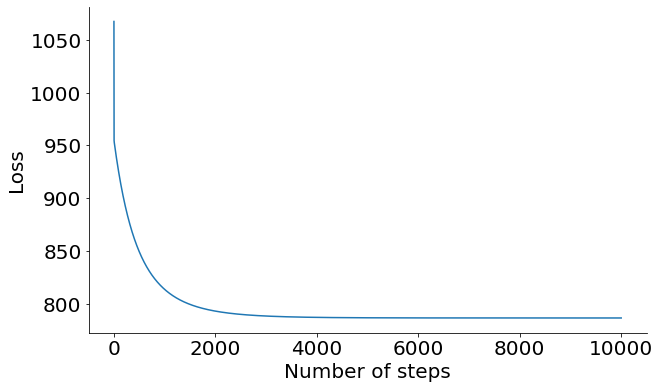

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Number of steps', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

In [70]:
print(a)
print(b)

6.34478779056682
-1.1252187175282786


In [71]:
logistic_reg.params

Intercept    6.360323
Rate        -1.127767
dtype: float64

## Back to Nomis

In [72]:
# Finding the best APR for our segment

# Try a range of APRs
APRs = np.linspace(3, 10)

# Find the loan revenues for each of these APRs
loan_revs = [loan_rev(i, 1.412, 60, 22000) for i in APRs]

# Find the probability of accepting for each of these APRs
prob_accept = logistic_reg.predict(pd.DataFrame({'Rate':APRs}))

# Find the profit for each APR
profits = [i*j for i,j in zip(loan_revs, prob_accept)]

# Find the best profit and best APR
best_profit = max(profits)
print(f'Best profit: ${round(best_profit,2)}')
best_apr = APRs[np.argmax(profits)]
print(f'Best APR: {round(best_apr,2)}%')

Best profit: $23.9
Best APR: 4.71%


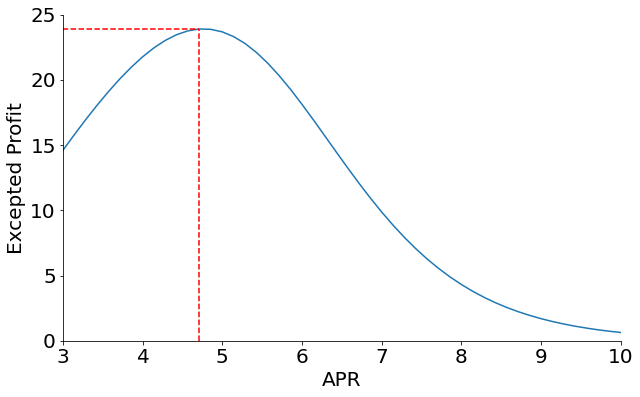

In [73]:
plt.figure(figsize=(10, 6))

plt.plot(APRs, profits)

plt.plot([best_apr, best_apr], [0, best_profit], color='red', linestyle='--')
plt.plot([2, best_apr], [best_profit, best_profit], color='red', linestyle='--')

plt.xlabel('APR', fontsize=20)
plt.ylabel('Excepted Profit', fontsize=20)
plt.xlim([3,10])
plt.ylim([0,25])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

## Multivariate logistic regression

In [74]:
# Ensure there are no spaces in the names of the columns so that we
# can carry out a logistic regression using *all* the variables
df_nomis.columns = [i.replace(' ', '_') for i in df_nomis.columns]

In [75]:
df_nomis.columns

Index(['Tier', 'FICO', 'Approve_Date', 'Term', 'Amount', 'Previous_Rate',
       'Car_Type', 'Competition_rate', 'Outcome', 'Rate', 'Cost_of_Funds',
       'Partner_Bin'],
      dtype='object')

In [76]:
# Fit the full logistic regression
full_logistic_reg = smf.logit('''Outcome
                                    ~   C(Tier)
                                      + FICO
                                      + C(Term)
                                      + Amount
                                      + C(Car_Type)
                                      + Competition_rate
                                      + Rate
                                      + Cost_of_Funds
                                      + C(Partner_Bin)''', data = df_nomis).fit()

Optimization terminated successfully.
         Current function value: 0.383276
         Iterations 7


In [77]:
full_logistic_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:               208085
Model:                          Logit   Df Residuals:                   208068
Method:                           MLE   Df Model:                           16
Date:                Wed, 20 Sep 2023   Pseudo R-squ.:                  0.2727
Time:                        11:59:12   Log-Likelihood:                -79754.
converged:                       True   LL-Null:                   -1.0965e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.9190      0.235     25.178      0.000       5.458       6.380
C(Tier)[T.2]           -0.2662      0.022    -11.957      0.000      -0.310      -0.223
C(Tier)[T.3]           -0.2550      0.029     -8.697      0.000      -0.312      -0.198
C(Tier)[T.4]           -0.0159      0.045     -0.350      0.726      -0.105       0.073
C(Term)[T.48]           0.2678      0.024     11.111      0.000       0.221       0.315
C(Term)[T.60]           0.7394      0.022     34.115      0.000       0.697       0.782
C(Term)[T.66]           0.9063      0.052     17.420      0.000       0.804       1.008
C(Term)[T.72]           1.5954      0.036     43.850      0.000       1.524       1.667
C(Car_Type)[T.R]        1.8155      0.024     74.721      0.000       1.768       1.863
C(Car_Type)[T.U]        2.1393      0.019    114.694      0.000       2.103       2.176
C(Partner_Bin)[T.2]    -1.4557      0.022    -64.888      0.000      -1.500      -1.412
C(Partner_Bin)[T.3]    -0.2929      0.013    -21.948      0.000      -0.319      -0.267
FICO                   -0.0069      0.000    -24.332      0.000      -0.007      -0.006
Amount              -8.523e-05   8.82e-07    -96.641      0.000    -8.7e-05   -8.35e-05
Competition_rate        0.1594      0.022      7.195      0.000       0.116       0.203
Rate                   -0.5072      0.009    -59.200      0.000      -0.524      -0.490
Cost_of_Funds           0.3654      0.030     12.366      0.000       0.308       0.423
=======================================================================================
"""

In [78]:
def pricing_helper(Tier = 3,
                     FICO = 697,
                     Term = 60,
                     Amount = 21400,
                     Car_Type = 'U',
                     Competition_rate = 4.8,
                     Cost_of_Funds = 1.3,
                     Partner_Bin = 3):
    # Try a range of APRs
    APRs = np.linspace(2, 10)
    
    # Find the revenue at each APR
    loan_revs = [loan_rev(i, Cost_of_Funds, Term, Amount) for i in APRs]
    
    # Use the full logistic regression to find the probability of the
    # loan getting accepted at each APR
    df = pd.DataFrame({'Tier':Tier,
                       'FICO':FICO,
                       'Term':Term,
                       'Amount':Amount,
                       'Car_Type':Car_Type,
                       'Competition_rate':Competition_rate,
                       'Cost_of_Funds':cost_of_funds,
                       'Partner_Bin':Partner_Bin,
                       'Rate':APRs})
    
    prob_accept = full_logistic_reg.predict(df)
    
    # Calculate the profit
    profit = [i*j for i, j in zip(loan_revs, prob_accept)]
    
    # Figure out the best profit and plot it
    best_profit = max(profit)
    best_apr = APRs[np.argmax(profit)]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(APRs, profit)
    
    plt.plot([best_apr, best_apr], [0, best_profit], color='red', linestyle='--')
    plt.plot([1, best_apr], [best_profit, best_profit], color='red', linestyle='--')
    
    plt.xlabel('APR', fontsize=20)
    plt.ylabel('Excepted Profit', fontsize=20)
    
    plt.xlim([2, 10])
    plt.ylim(bottom=0)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.text(best_apr+0.1, 1, f'Best APR: {round(best_apr,2)}%', color='red', fontsize=20)
    
    sns.despine()

In [79]:
from ipywidgets import interact, FloatSlider

In [80]:
interact(pricing_helper,
            Tier = [1,2,3,4],
            FICO = FloatSlider(min=585, max=860, value=697, continuous_update=False),
            Term = [36, 48, 60, 66, 72],
            Amount = FloatSlider(min=5, max=100000, value=21400, continuous_update=False),
            Car_Type = ['N', 'U', 'R'],
            Competition_rate = FloatSlider(min=2.99, max=6.45, value=4.8, continuous_update=False),
            Cost_of_Funds = FloatSlider(min=1.02, max=2.127, value=1.3, continuous_update=False),
            Partner_Bin = [1,2,3])

interactive(children=(Dropdown(description='Tier', index=2, options=(1, 2, 3, 4), value=3), FloatSlider(value=…

<function __main__.pricing_helper(Tier=3, FICO=697, Term=60, Amount=21400, Car_Type='U', Competition_rate=4.8, Cost_of_Funds=1.3, Partner_Bin=3)>

## Calibration

Optimization terminated successfully.
         Current function value: 0.286048
         Iterations 8


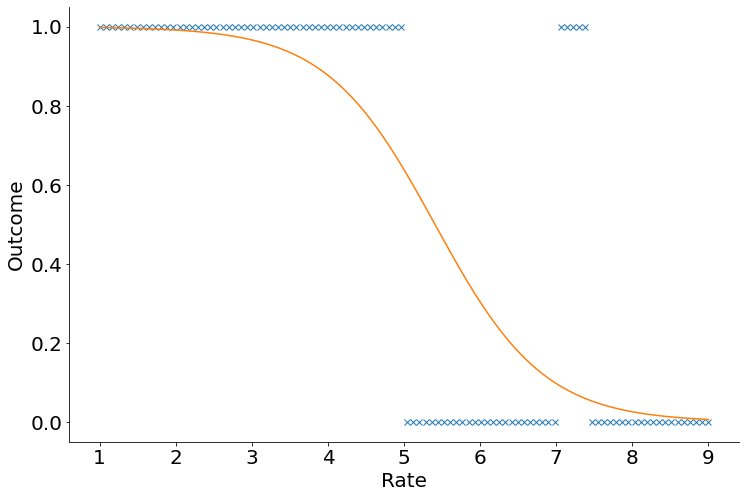

In [81]:
optional_material()

x = np.linspace(1, 9, num=100)
y = [1]*50 + [0]*25 + [1]*5 + [0]*20

df_test = pd.DataFrame({'x':x, 'y':y})

lr_test = smf.logit('y ~ x', data=df_test).fit()

plt.figure(figsize=(12, 8))
plt.plot(x,y, linewidth=0, marker='x')

lr_curve = lr_test.predict(pd.DataFrame({'x':x}))
plt.plot(x, lr_curve)

plt.xlabel('Rate', fontsize=20)
plt.ylabel('Outcome', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

In [82]:
df_nomis_cal = df_nomis.copy()
df_nomis_cal['predictions'] = full_logistic_reg.predict(df_nomis_cal)

In [83]:
model_probs = np.linspace(0.05, 0.95, num=10)
true_probs = []

for prob in model_probs:
    true_probs.append(df_nomis_cal[(df_nomis_cal.predictions >= prob-0.05)
                                 & (df_nomis_cal.predictions <= prob+0.05)].Outcome.mean())

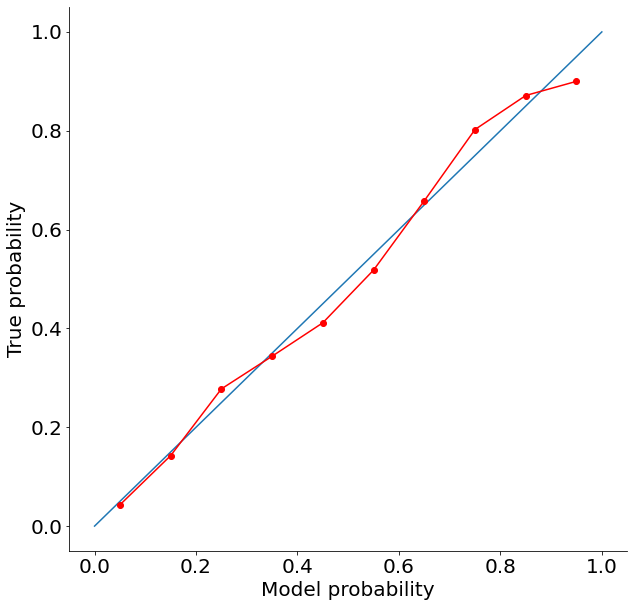

In [84]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1])
plt.plot(model_probs, true_probs, color='red', marker='o')

plt.xlabel('Model probability', fontsize=20)
plt.ylabel('True probability', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.despine()

## Isotonic regression

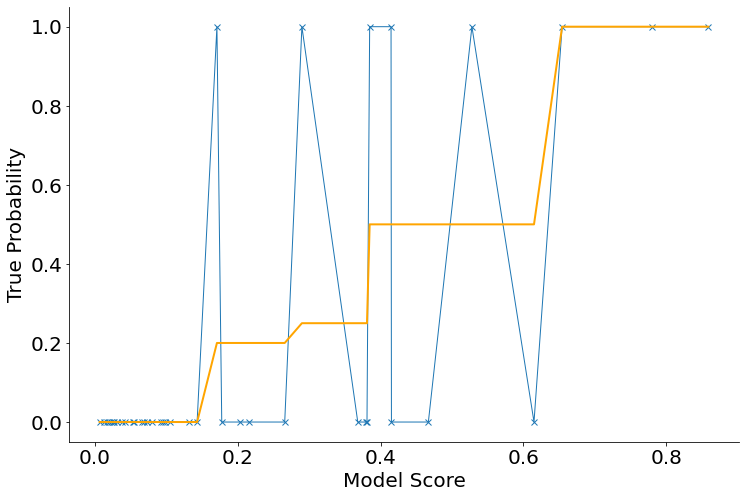

In [85]:
optional_material()

# Display a subset of the Nomis data with
#   (a) the function that best fits the point in blue
#   (b) the INCREASING function that best fits the points
#       in orange

plt.figure(figsize=(12, 8))

df_small_sample = df_nomis_cal.sample(n=40, random_state=9).sort_values('predictions')
scores = df_small_sample.predictions.tolist()
y = df_small_sample.Outcome.tolist()
plt.plot(scores, y, marker='x', linewidth=1)

import sklearn.isotonic as sk_i
isotonic_reg = sk_i.IsotonicRegression().fit(scores, y)
plt.plot(scores, isotonic_reg.predict(scores), color='orange', linewidth=2)

plt.xlabel('Model Score', fontsize=20)
plt.ylabel('True Probability', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.despine()

In [86]:
optional_material()

# Demonstrate the pair-adjacent violators algorithm

def save_update(active_point, foward, file_name):
    '''
    This function will plot the current state of the pair-adjacent
    violators algorithm and save it to a file in the "PAV demo"
    folder
    
    It takes the following arguments:
      - active_point: the index of the current point in the algorithm
      - forward: True if we're moving forward, False if backwards
      - file_name: the filename to save this step as
    '''
    
    plt.figure(figsize=(13, 8))

    # Plot the points, and the current isotonic function
    plt.plot(scores, y, linewidth=0, marker='o')
    plt.plot(scores, z, linewidth=0.8, color='orange', marker='x')

    # Plot a vertical line noting the current position of the algorithm,
    # together with an arrow indicating its direction
    plt.plot([scores[active_point], scores[active_point]], [0, 1], linewidth=0.5, color='red')
    
    plt.plot(scores[active_point],
             0.5,
             markersize = 25,
             marker = '$\\rightarrow$' if forward else '$\\leftarrow$',
             color='red')

    plt.xticks(fontsize=20)
    plt.yticks([0, 1], fontsize=20)

    sns.despine()
    
    # Save the file, an close the matplotlib plots so they don't display
    plt.savefig(f'{str(file_name).rjust(5,"0")}.png')
    plt.close()
    
# Initialize the algorithm with the y values
z = list(y)

# Initialize the position and direction of the algorithm
pos = 0
forward = True

# Initialize the figure number
fig_n = 0

while pos < len(scores) - 1:
    # Increment the figure number and plot and update
    fig_n += 1
    save_update(pos, forward, fig_n)
    
    if forward:
        # If the next point is smaller than this one, replace them
        # both by the average and go backwards
        if z[pos] > z[pos+1]:
            z[pos] = z[pos+1] = (z[pos]+z[pos+1])/2
            last_forward = pos+1
            forward = False
        else:
            pos += 1

    else:
        # We're going backwards. If the previous point is larger than
        # this one, set all the points from here until the last point we
        # went forward to the average of all of them
        if z[pos-1] > z[pos]:
            av = np.mean(z[(pos-1):(last_forward+1)])
            for j in range(pos-1, last_forward+1):
                z[j] = av
            
            pos -= 1
        else:
            last_forward = None
            forward = True
            

#1. chatgpt 2.stack overflow 3. geeksforgeeks

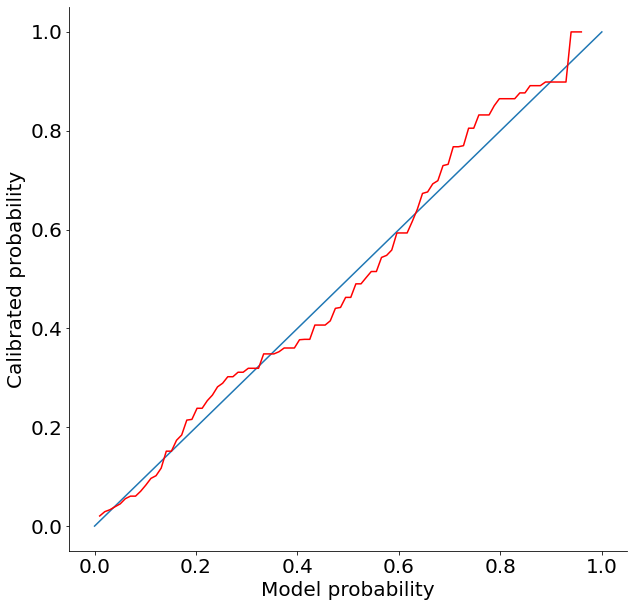

In [87]:
import sklearn.isotonic as sk_i

i_r = sk_i.IsotonicRegression().fit(df_nomis_cal.predictions, df_nomis_cal.Outcome)

model_probs = np.linspace(0, 1, num=100)
calibrated_probs = i_r.predict(model_probs)

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1])
plt.plot(model_probs, calibrated_probs, color='red')

plt.xlabel('Model probability', fontsize=20)
plt.ylabel('Calibrated probability', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.despine()